In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
from invert.evaluate import eval_auc

pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


In [3]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1000,
    n_sources=15,
    n_orders=(0, 3),
    snr_range=(1e99, 2e99),
    n_timecourses=2000,
    n_timepoints=20,
    scale_data=False, 
    add_forward_error=False,
    forward_error=0.3)

gen = generator(fwd, **sim_params)

No projector specified for this dataset. Please consider the method self.add_proj.


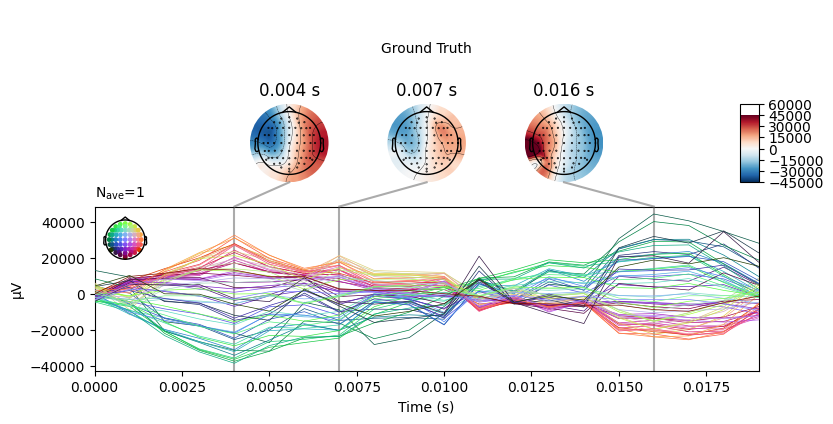

In [4]:
x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# SVD Compression

In [7]:
from copy import deepcopy
D = deepcopy(y)
D = D.reshape(D.shape[2], D.shape[0]*D.shape[1])
# print(D.shape)
U, s, V = np.linalg.svd(D, full_matrices=False)

In [8]:
plt.figure()
plt.plot(s)

In [76]:
from scipy.sparse.csgraph import laplacian

class Compressor:
    ''' Compression using Graph Fourier Transform
    '''
    def __init__(self):
        pass
    def fit(self, fwd, k=600):
        A = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
        # D = np.diag(A.sum(axis=0))
        # L = D-A
        L = laplacian(A)
        U, s, V = np.linalg.svd(L, full_matrices=False)

        self.U = U[:, -k:]
        self.s = s[-k:]
        self.V = V[:, -k:]
        # self.U = U[:, :k]
        # self.s = s[:k]
        # self.V = V[:, :k]
        return self
        
    def encode(self, X):
        ''' Encodes a true signal X
        Parameters
        ----------
        X : numpy.ndarray
            True signal
        
        Return
        ------
        X_comp : numpy.ndarray
            Compressed signal
        '''
        X_comp = self.U.T @ X

        return X_comp

    def decode(self, X_comp):
        ''' Decodes a compressed signal X

        Parameters
        ----------
        X : numpy.ndarray
            Compressed signal
        
        Return
        ------
        X_unfold : numpy.ndarray
            Decoded signal
        '''
        X_unfold = self.U @ X_comp

        return X_unfold

In [81]:
k = 100
comp = Compressor().fit(fwd, k=k)


In [82]:
D = y[7].T

D_enc = comp.encode(D)
D_dec = comp.decode(D_enc)

stc_ = stc.copy()
stc_.data = D
stc_.plot(**pp, brain_kwargs=dict(title="Original"))

stc_ = stc.copy()
stc_.data = D_dec
stc_.plot(**pp, brain_kwargs=dict(title="Compressed"))


# cov = np.random.randn(k,k)
# cov = cov@cov.T
# random_input = cov @ np.random.rand(k, 20)
# D_rand = comp.decode(random_input)

# stc_ = stc.copy()
# stc_.data = D_rand
# stc_.plot(**pp, brain_kwargs=dict(title="Random"))


Using control points [4.25746484e-05 5.36772617e-05 3.28858409e-04]
Using control points [0.         0.         0.00154524]
Using control points [4.25746484e-05 5.36772617e-05 3.28858409e-04]
Using control points [0.00042113 0.00077448 0.00150585]
